In [1]:
import sys
import os
import anndata as ad
import pandas as pd
import scanpy as sc
import re
import numpy as np
import seaborn as sns; sns.set(color_codes=True)
import scimap as sm  
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from scipy.stats import pearsonr
import napari

Running SCIMAP  2.1.0


In [38]:
adata=ad.read(r"C:\Users\tav9\HMS Dropbox\Tuulia Vallius\PCA_phaseII\cycif_analysis_materials\PCAmerged_e41_allphenotypes_V4.h5ad")

C:\Users\tav9\AppData\Local\anaconda3\envs\scimap_new\lib\site-packages\anndata\__init__.py:55: FutureWarning:

`anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.



In [4]:
adata

AnnData object with n_obs × n_vars = 6312672 × 17
    obs: 'X_centroid', 'Y_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Solidity', 'Extent', 'Orientation', 'CellID', 'imageid', 'case', 'phenotype_all', 'phenotype_all2', 'KEEP'
    layers: 'rescaled'

In [5]:
mel=['MEL14']
MEL14=adata[(adata.obs['case'].isin(mel))]


In [6]:
MEL14

View of AnnData object with n_obs × n_vars = 68355 × 17
    obs: 'X_centroid', 'Y_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Solidity', 'Extent', 'Orientation', 'CellID', 'imageid', 'case', 'phenotype_all', 'phenotype_all2', 'KEEP'
    layers: 'rescaled'

In [39]:
mel=['MEL71']
MEL71=adata[(adata.obs['case'].isin(mel))]

In [40]:
MEL71

View of AnnData object with n_obs × n_vars = 609089 × 17
    obs: 'X_centroid', 'Y_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Solidity', 'Extent', 'Orientation', 'CellID', 'imageid', 'case', 'phenotype_all', 'phenotype_all2', 'KEEP'
    layers: 'rescaled'

In [9]:
mel=['MEL74']
MEL74=adata[(adata.obs['case'].isin(mel))]

In [10]:
MEL74

View of AnnData object with n_obs × n_vars = 261318 × 17
    obs: 'X_centroid', 'Y_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Solidity', 'Extent', 'Orientation', 'CellID', 'imageid', 'case', 'phenotype_all', 'phenotype_all2', 'KEEP'
    layers: 'rescaled'

In [49]:
all_markers = ['DNA1','5hmC','Tet2','SOX10','DNA2','LaminA/C/B1','GATA3','PMEL','DNA3','SOX9','S100B','MART1','aSMA','DNA4','MITF','CD63','p21','panCK','DNA5','ECAD','pSTAT1','MCM2','S100A1','DNA6','Ki67','pSTAT3','PD1','pH3','DNA7','PRAME','IRF5','IRF1','B2M','DNA8','MX1','CD11c','NGFR','CK14','DNA9','LDH','pERK','BCL2','VIM','DNA10','CD3e','SOX2','MCL1','pS6','DNA11','CCND1','CCNA2','PDL1','PCNA','DNA12','p16/CDKN2A','SOX6','HIF1a','H3k27me3']

# Add ROIs with segmentation masks and specific overlay categories
sm.pl.addROI_image(image_path=r"Y:\cycif-production\16-Pre-Cancer-Atlas-for-Melanoma\PCA_p16_e41_tumor_intrinsic\quantified\LSP11314\registration\LSP11314.ome.tif", adata=MEL14,
             overlay='phenotype_all2', channel_names=all_markers, label='ROI_to_remove')


        Opening Napari;
        Add shape layers (on left) to draw ROI's. 
        Rename the shape layer to give a name to your ROI
        Multiple shape layers are supported
        ROI's should not overlap
        Close Napari to save ROI's.
        
Identifying cells within selected ROI's
ROIs saved under adata.obs['ROI_to_remove']


C:\Users\tav9\AppData\Local\anaconda3\envs\scimap_new\lib\site-packages\scimap\plotting\addROI_image.py:466: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.



AnnData object with n_obs × n_vars = 68355 × 17
    obs: 'X_centroid', 'Y_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Solidity', 'Extent', 'Orientation', 'CellID', 'imageid', 'case', 'phenotype_all', 'phenotype_all2', 'KEEP', 'ROI_to_remove'
    layers: 'rescaled'

In [50]:
MEL14.obs.ROI_to_remove.value_counts()

ROI_to_remove
Other            67817
ROI_to_remove      538
Name: count, dtype: int64

In [51]:
cells=['Other']
MEL14=MEL14[(MEL14.obs['ROI_to_remove'].isin(cells))]

In [50]:
from scipy.ndimage import gaussian_filter

#test, contour mask for only tumor cells
def plot_tumor_marker_intensity_with_contours_dots(df, marker_name, cell_type_col, tumor_cell_type, sigma=2, levels=10, n_bins=50, dot_size=20):
    """Plots marker intensity, contours, and dots with correct histogram calculation."""

    x = df['x'].values
    y = df['y'].values
    intensity = df[marker_name].values
    cell_types = df[cell_type_col].values

    tumor_mask = cell_types == tumor_cell_type
    x_tumor = x[tumor_mask]
    y_tumor = y[tumor_mask]
    intensity_tumor = intensity[tumor_mask]
    
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()

    xi = np.linspace(x_min, x_max, n_bins)
    yi = np.linspace(y_min, y_max, n_bins)

    # Calculate 2D histogram for *ALL* cells (for contours), but WITHOUT weights
    hist, xedges, yedges = np.histogram2d(x_tumor, y_tumor, bins=(xi, yi), weights=intensity_tumor)
    hist_smooth = gaussian_filter(hist.T, sigma=sigma)


    # Corrected contour plotting: Use xedges and yedges directly
    #plt.figure(figsize=(8, 8))
    #plt.imshow(hist_smooth, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin='lower', cmap='jet', aspect='auto')
    #plt.colorbar(label=f'{marker_name} Intensity')

    contour_levels = np.linspace(hist_smooth.min(), hist_smooth.max(), levels)
    plt.figure(figsize=(3, 3))

    # Then plot the scatter plot (tumor cells colored, others grey)
    tumor_mask = cell_types == tumor_cell_type
    plt.scatter(x[~tumor_mask], y[~tumor_mask], c='silver', s=dot_size)#, label='Other')
    plt.scatter(x[tumor_mask], y[tumor_mask], c=intensity[tumor_mask], s=dot_size, cmap='Reds', vmin=0.4,vmax=0.8)#,label=f'{tumor_cell_type}')
    #plt.colorbar(label=f'{marker_name} Intensity')

    plt.contour(xedges[:-1], yedges[:-1], hist_smooth, levels=contour_levels, colors='black', linewidths=0.5, add=True)   

    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title(f'{marker_name} Intensity in {tumor_cell_type}')
    plt.legend()

    plt.xlim(x.min(), x.max())
    plt.ylim(y.min(), y.max())

    plt.tight_layout()
    #plt.savefig("C:/Users/tav9/Dropbox (HMS)/test/test/contour_plot_MEL14_MART1_intensity_Fig1_colorbar.pdf")
    plt.savefig("C:/Users/tav9/Dropbox (HMS)/test/test/contour_plot_MEL71_MART1_intensity_Fig1_microregion.pdf")
    plt.show()

C:\Users\tav9\AppData\Local\Temp\ipykernel_60544\195737607.py:42: UserWarning:

The following kwargs were not used by contour: 'add'

C:\Users\tav9\AppData\Local\Temp\ipykernel_60544\195737607.py:47: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



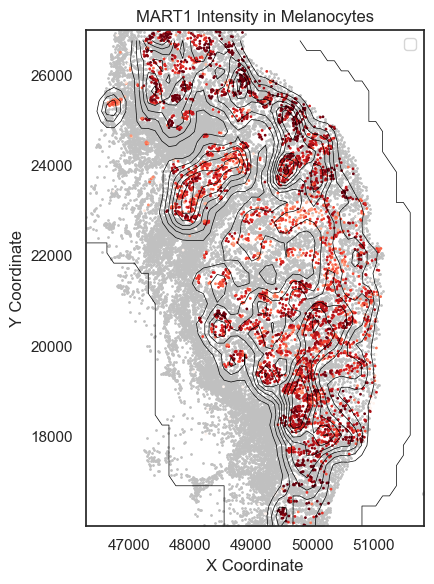

In [6]:
#tmp = MEL14[MEL14.obs['Y_centroid'] > 17000 ]
#tmp = tmp[tmp.obs['Y_centroid'] < 27000 ]
#tmp = tmp[tmp.obs['X_centroid'] >47000 ]
#tmp = tmp[tmp.obs['X_centroid'] < 56000 ]

tmp = MEL14[MEL14.obs['Y_centroid'] > 16000 ]
tmp = tmp[tmp.obs['Y_centroid'] < 27000 ]

tmp = tmp[tmp.obs['X_centroid'] >46000 ]
#tmp = tmp[tmp.obs['X_centroid'] < 56000 ]

df_tmp=tmp.to_df(layer=None)
df_tmp['x']=tmp.obs['X_centroid']
df_tmp['y']=tmp.obs['Y_centroid']
df_tmp['phenotype_all2']=tmp.obs['phenotype_all2']

plot_tumor_marker_intensity_with_contours_dots(df_tmp, 'MART1', 'phenotype_all2', 'Melanocytes', sigma=1, levels=10, dot_size=1)

C:\Users\tav9\AppData\Local\Temp\ipykernel_60544\1331908653.py:42: UserWarning:

The following kwargs were not used by contour: 'add'

C:\Users\tav9\AppData\Local\Temp\ipykernel_60544\1331908653.py:47: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



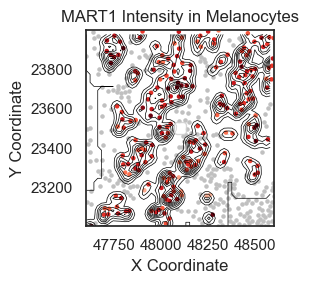

In [37]:
tmp = MEL14[MEL14.obs['Y_centroid'] > 23000 ]
tmp = tmp[tmp.obs['Y_centroid'] < 24000 ]

tmp = tmp[tmp.obs['X_centroid'] >47600 ]
tmp = tmp[tmp.obs['X_centroid'] < 48600 ]

df_tmp=tmp.to_df(layer=None)
df_tmp['x']=tmp.obs['X_centroid']
df_tmp['y']=tmp.obs['Y_centroid']
df_tmp['phenotype_all2']=tmp.obs['phenotype_all2']

plot_tumor_marker_intensity_with_contours_dots(df_tmp, 'MART1', 'phenotype_all2', 'Melanocytes', sigma=1, levels=10, dot_size=5)

In [139]:
MEL14.obs.phenotype_all2.value_counts()

phenotype_all2
Keratinocytes      23766
Unknown            23168
Melanocytes         8936
T cells             8731
Myeloid lineage     3216
Name: count, dtype: int64

In [153]:
sm.hl.classify(MEL14, pos=['MART1'], neg=None, classify_label='MART1+', phenotype='phenotype_all2', 
               subclassify_phenotype='Melanocytes', threshold=0.5, collapse_failed=False, label='MART1pos')
rename= {'MART1+': ['MART1+'],
        'MART1-':['Melanocytes']}
MEL14 = sm.hl.rename(MEL14, rename, from_column='MART1pos', to_column='MART1pos')

sm.hl.classify(MEL14, pos=['NGFR'], neg=None, classify_label='NGFR+', phenotype='phenotype_all2', 
               subclassify_phenotype='Melanocytes', threshold=0.5, collapse_failed=False, label='NGFRpos')
rename= {'NGFR+': ['NGFR+'],
        'NGFR-':['Melanocytes']}
MEL14 = sm.hl.rename(MEL14, rename, from_column='NGFRpos', to_column='NGFRpos')

Renaming MART1+ to MART1+
Renaming Melanocytes to MART1-
Renaming NGFR+ to NGFR+
Renaming Melanocytes to NGFR-


In [154]:
MEL14.obs.MART1pos.value_counts()

MART1pos
Keratinocytes      23766
Unknown            23168
T cells             8731
MART1+              7988
Myeloid lineage     3216
MART1-               948
Name: count, dtype: int64

In [155]:
MEL14

AnnData object with n_obs × n_vars = 67817 × 17
    obs: 'X_centroid', 'Y_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Solidity', 'Extent', 'Orientation', 'CellID', 'imageid', 'case', 'phenotype_all', 'phenotype_all2', 'KEEP', 'ROI_to_remove', 'MART1pos', 'NGFRpos'
    layers: 'rescaled'

In [159]:
y=['MART1-','MART1+']
x=['Melanocytes']
b=sm.pl.stacked_barplot(MEL14, y_axis='MART1pos', x_axis='phenotype_all2', 
                      subset_xaxis=x, subset_yaxis=y, order_xaxis=None, order_yaxis=None, 
                      method='percent', figsize=(1,3), return_data=True, fileName='MEL14_VGP_MART1.pdf', saveDir='C:/Users/tav9/HMS Dropbox/Tuulia Vallius/test/test/')

Saved plot to C:/Users/tav9/HMS Dropbox/Tuulia Vallius/test/test/MEL14_VGP_MART1.pdf


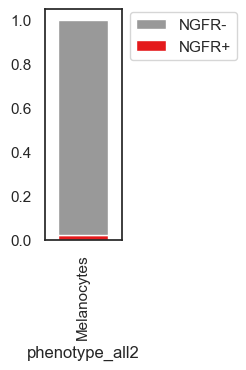

In [3]:
y=['NGFR-','NGFR+']
x=['Melanocytes']
b=sm.pl.stacked_barplot(MEL14, y_axis='NGFRpos', x_axis='phenotype_all2', 
                      subset_xaxis=x, subset_yaxis=y, order_xaxis=None, order_yaxis=None, 
                      method='percent', figsize=(1,3), return_data=True)#, fileName='MEL18_geoMX_MART1.pdf', saveDir='C:/Users/tav9/HMS Dropbox/Tuulia Vallius/test/test/')

In [160]:
MEL14.write(r"C:\Users\tav9\HMS Dropbox\Tuulia Vallius\PCA_phaseII\cycif_analysis_materials\data\Fig1_MEL14_contour_plot.h5ad")

In [2]:
MEL14=ad.read(r"C:\Users\tav9\HMS Dropbox\Tuulia Vallius\PCA_phaseII\cycif_analysis_materials\data\Fig1_MEL14_contour_plot.h5ad")

C:\Users\tav9\AppData\Local\anaconda3\envs\scimap_new\lib\site-packages\anndata\__init__.py:55: FutureWarning:

`anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.



C:\Users\tav9\AppData\Local\Temp\ipykernel_60544\927509612.py:42: UserWarning:

The following kwargs were not used by contour: 'add'

C:\Users\tav9\AppData\Local\Temp\ipykernel_60544\927509612.py:47: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



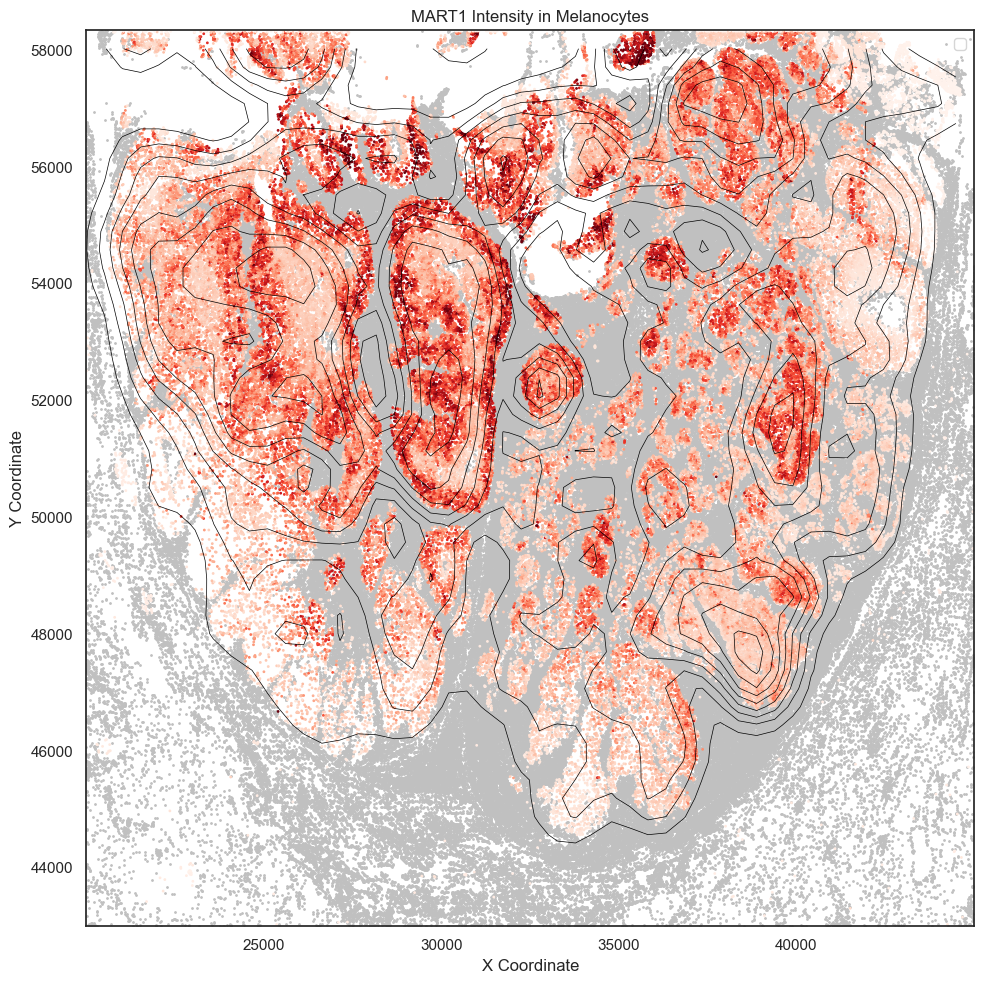

In [43]:
tmp = MEL71[MEL71.obs['Y_centroid'] > 43000 ]
#tmp = tmp[tmp.obs['Y_centroid'] < 27000 ]

tmp = tmp[tmp.obs['X_centroid'] >20000 ]
tmp = tmp[tmp.obs['X_centroid'] < 45000 ]

df_tmp=tmp.to_df(layer=None)
df_tmp['x']=tmp.obs['X_centroid']
df_tmp['y']=tmp.obs['Y_centroid']
df_tmp['phenotype_all2']=tmp.obs['phenotype_all2']

plot_tumor_marker_intensity_with_contours_dots(df_tmp, 'MART1', 'phenotype_all2', 'Melanocytes', sigma=1, levels=10, dot_size=1)

C:\Users\tav9\AppData\Local\Temp\ipykernel_60544\4136417749.py:42: UserWarning:

The following kwargs were not used by contour: 'add'

C:\Users\tav9\AppData\Local\Temp\ipykernel_60544\4136417749.py:47: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



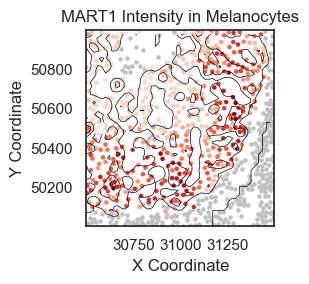

In [51]:
tmp = MEL71[MEL71.obs['Y_centroid'] > 50000 ]
tmp = tmp[tmp.obs['Y_centroid'] < 51000 ]

tmp = tmp[tmp.obs['X_centroid'] >30500 ]
tmp = tmp[tmp.obs['X_centroid'] < 31500 ]

df_tmp=tmp.to_df(layer=None)
df_tmp['x']=tmp.obs['X_centroid']
df_tmp['y']=tmp.obs['Y_centroid']
df_tmp['phenotype_all2']=tmp.obs['phenotype_all2']

plot_tumor_marker_intensity_with_contours_dots(df_tmp, 'MART1', 'phenotype_all2', 'Melanocytes', sigma=1, levels=5, dot_size=5)

In [157]:
sm.hl.classify(MEL71, pos=['MART1'], neg=None, classify_label='MART1+', phenotype='phenotype_all2', 
               subclassify_phenotype='Melanocytes', threshold=0.5, collapse_failed=False, label='MART1pos')
rename= {'MART1+': ['MART1+'],
        'MART1-':['Melanocytes']}
MEL71 = sm.hl.rename(MEL71, rename, from_column='MART1pos', to_column='MART1pos')

sm.hl.classify(MEL71, pos=['NGFR'], neg=None, classify_label='NGFR+', phenotype='phenotype_all2', 
               subclassify_phenotype='Melanocytes', threshold=0.5, collapse_failed=False, label='NGFRpos')
rename= {'NGFR+': ['NGFR+'],
        'NGFR-':['Melanocytes']}
MEL71 = sm.hl.rename(MEL71, rename, from_column='NGFRpos', to_column='NGFRpos')

C:\Users\tav9\AppData\Local\anaconda3\envs\scimap_new\lib\site-packages\scimap\helpers\classify.py:184: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.



Renaming MART1+ to MART1+
Renaming Melanocytes to MART1-
Renaming NGFR+ to NGFR+
Renaming Melanocytes to NGFR-


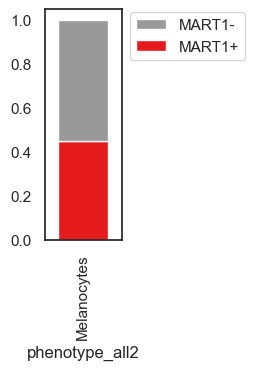

In [158]:
y=['MART1-','MART1+']
x=['Melanocytes']
b=sm.pl.stacked_barplot(MEL71, y_axis='MART1pos', x_axis='phenotype_all2', 
                      subset_xaxis=x, subset_yaxis=y, order_xaxis=None, order_yaxis=None, 
                      method='percent', figsize=(1,3), return_data=True)#, fileName='MEL18_geoMX_MART1.pdf', saveDir='C:/Users/tav9/HMS Dropbox/Tuulia Vallius/test/test/')

C:\Users\tav9\AppData\Local\Temp\ipykernel_24520\2482981717.py:42: UserWarning:

The following kwargs were not used by contour: 'add'



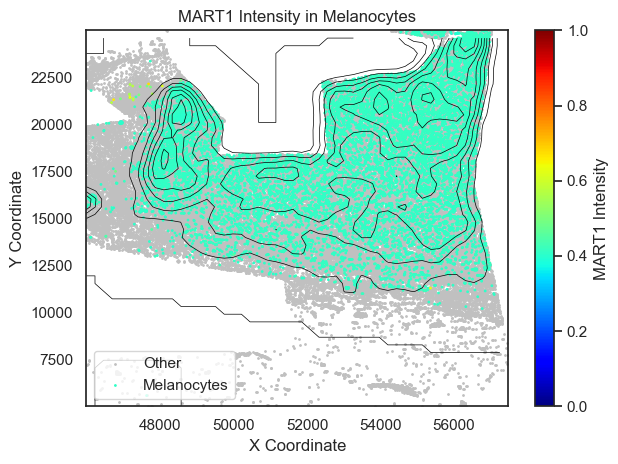

In [72]:
tmp = MEL74[MEL74.obs['Y_centroid'] > 5000 ]
tmp = tmp[tmp.obs['Y_centroid'] < 25000 ]

tmp = tmp[tmp.obs['X_centroid'] > 46000 ]
tmp = tmp[tmp.obs['X_centroid'] < 60000 ]

df_tmp=tmp.to_df(layer=None)
df_tmp['x']=tmp.obs['X_centroid']
df_tmp['y']=tmp.obs['Y_centroid']
df_tmp['phenotype_all2']=tmp.obs['phenotype_all2']

plot_tumor_marker_intensity_with_contours_dots(df_tmp, 'MART1', 'phenotype_all2', 'Melanocytes', sigma=1, levels=10, dot_size=1)